In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [4]:
torch.cuda.set_device(0)

In [6]:
!nvidia-smi

Sun Oct 20 20:52:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.116                Driver Version: 390.116                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P0    65W / 250W |    370MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-bengali/language-model')

In [8]:
from inltk.tokenizer import BengaliTokenizer

In [9]:
BengaliTokenizer

inltk.tokenizer.BengaliTokenizer

In [8]:
# class BengaliTokenizer(BaseTokenizer):
#     def __init__(self, lang:str):
#         self.lang = lang
#         self.sp = spm.SentencePieceProcessor()
#         self.sp.Load(str(path/"../tokenizer/bengali_lm.model"))
        
#     def tokenizer(self, t:str) -> List[str]:
#         return self.sp.EncodeAsPieces(t)

In [10]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/bengali_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [11]:
# 30,000 is the vocab size that we chose in sentencepiece
bengali_vocab = Vocab(itos)

In [12]:
tokenizer = Tokenizer(tok_func=BengaliTokenizer, lang='bn')

In [13]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [14]:
data_lm = TextLMDataBunch.from_folder(path=path/'transformer', tokenizer=tokenizer, vocab=bengali_vocab)

In [15]:
data_lm.batch_size

64

In [16]:
data_lm.save()

In [17]:
data_lm.show_batch()

idx,text
0,"▁নদ ▁ইত্যাদি ▁নামে ▁অভিহিত ▁করা ▁যায় । ▁আবার ▁ভৌগোলিক ▁অঞ্চলভেদে ▁ছোট ▁নদী কে ▁বিভিন্ন ▁নামে ▁ডাকা ▁হয় । <unk> ▁m . m ori s wa এর ▁মতে ▁নদী ▁হল ▁খাতের ▁মধ ▁্য ▁দিয়ে ▁প্রবাহিত ▁জলধারা । - r ive r ▁is ▁a ▁can al ▁ flow . ▁সাধারণত ▁উঁচু ▁ভূমি ▁বা ▁পাহাড় ▁গিরিখাত ▁থেকে ▁সৃষ্ট ▁ঝরণা ধারা , ▁বরফ গল িত ▁স্রোত ▁কিংবা ▁প্রাকৃতিক ▁পরিবর্তন ▁থেকে ▁নদীর ▁জন্ম । ▁হাজার"
1,† p an the ra ▁z d ans ky i † ▁প্যান থে রা ▁গন টির ▁রয়েছে ▁নিম্নোক্ত ▁বাঘের ▁প্রজাতি ▁ও ▁উপপ্রজাতি গুলো । ▁প্যান থে রা ▁গন ে ▁রয়েছে ▁নিম্নোক্ত ▁সিংহের ▁প্রজাতি ▁ও ▁উপপ্রজাতি গুলো । ▁প্যান থে রা ▁গন ে ▁রয়েছে ▁নিম্নোক্ত ▁জাগ ুয়া র ের ▁প্রজাতি ▁ও ▁উপপ্রজাতি গুলো । ▁প্যান থে রা ▁গন ▁ টিতে ▁রয়েছে ▁নিম্নোক্ত ▁চিতাবাঘ ▁গুলোর ▁প্রজাতি ▁ও ▁উপপ্রজাতি গুলো । ▁বৈজ্ঞানিক ▁নাম
2,"▁পরিবার ▁থেকে ▁মাংস , ▁সমৃদ্ধ ▁এবং ▁আরো ▁সম্ভ্রান্ত ▁পরিবার ▁এর ▁সাথে ▁সম্পর্কিত , ▁কুন ল ▁প্যা ট্রি সিও ▁তার ▁মা ▁ছিলেন ▁একজন ▁ধার্মিক ▁ক্যাথলিক ▁যিনি ▁তার ▁ছেলেকে ও ▁এক ▁হয়েছিলেন । ▁এছাড়াও ▁তিনি ▁গবেষণা ▁আইন ▁এ , ▁যেখানে ▁তিনি ▁তখন ▁একটি ▁অবৈধ ▁সংগঠন ▁সিএফ পি ▁যোগ ▁দেন ▁১৯৩১ ▁সালে ▁বিশ্ববিদ্যালয় ের <unk> ▁তার ▁ছোট ▁বোন ▁মেরি ▁মান ্যু টা ▁বার র ের ইন হাস ▁কুন হাল ▁এবং ▁তার ▁বড় ▁ভাই"
3,"▁দিকে , ▁আমি ▁নিশ্চিত ▁ছিলাম ▁আমি ▁রিয়াল ▁মাদ্রিদে ▁থাক ব ▁কিন্তু ▁আমি ▁দেখ লাম ▁যে ▁আমার ▁কোচ ▁ও ▁মালিকের ▁আমার ▁প্রতি ▁সেই ▁বিশ্বাস টি ▁নেই । ▁আমি ▁একজন ▁খেলোয়াড় ▁যার ▁জন্যে ▁ওই ▁বিশ্বাস টি ▁অত্যন্ত ▁গুরুত্বপূর্ণ ▁ছিল ▁যা ▁আমি ▁মনে ▁করেছি ▁আর্সেনাল ের ▁আমার ▁প্রতি ▁ছিল , ▁এটাই ▁ছিল ▁সেই ▁কারণ ▁যা ▁আমাকে ▁আর্সেনাল ে ▁আসতে ▁প্রভাবিত ▁করেছে ।"" ▁রিয়াল ▁মাদ্রিদ ের ▁অনেক ▁খেলোয়াড় ▁তার ▁এই ▁দল ▁থেকে ▁চলে ▁যাওয়ার"
4,"▁x ▁৪০০ ▁মিটার ▁রিলে ▁ইভেন্টে ▁স্বর্ণ ▁পদক ▁জিতেছেন । ▁২৯ ▁জুন ▁২০১১ , ▁রয়টার্স ▁রিপোর্ট ▁করেন ▁যে , ▁তিনি ▁এন াবলি ক ▁স্টেরয়েড ▁মে থান ডি য়েন অন ▁এর ▁জন্য ▁ইতিবাচক ▁পরীক্ষিত ▁হয়েছে ▁এবং ▁অফ ▁সিজন ▁টেষ্ট ▁এ ▁স্ট্যান জো লো ল । ▁একই ▁দিনে ▁ভারতীয় ▁এ্যা থ লেট িক ▁ফেড ার েশান ▁ও ▁একই ▁ঘোষনা ▁দেন । ▁তিনি ▁ফলাফল ▁এর ▁জন্য ▁দায়ী ▁করেন ▁দূষিত ▁খাবার ▁কে ▁এবং ▁এই ▁রিপোর্ট"


In [18]:
len(data_lm.vocab.itos)

30000

In [19]:
learn = language_model_learner(data_lm, TransformerXL, pretrained=False)

In [20]:
gc.collect()

20

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


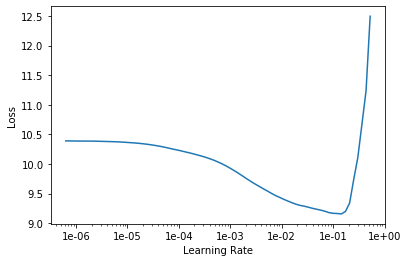

In [22]:
learn.recorder.plot()

In [23]:
learn.model

SequentialRNN(
  (0): TransformerXL(
    (encoder): Embedding(30000, 410)
    (pos_enc): PositionalEncoding()
    (drop_emb): Dropout(p=0.1)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadRelativeAttention(
          (attention): Linear(in_features=410, out_features=1230, bias=False)
          (out): Linear(in_features=410, out_features=410, bias=False)
          (drop_att): Dropout(p=0.1)
          (drop_res): Dropout(p=0.1)
          (ln): LayerNorm(torch.Size([410]), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=410, out_features=410, bias=False)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=410, out_features=2100, bias=True)
            (1): ReLU(inplace)
            (2): Dropout(p=0.1)
            (3): Linear(in_features=2100, out_features=410, bias=True)
            (4): Dropout(p=0.1)
            (5): MergeLayer()
            (6): LayerNorm(torch.Size([410]), eps

In [24]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,6.160033,6.114402,0.186740,35:35
1,5.363132,5.303140,0.232614,35:36
2,4.834630,4.814843,0.266739,35:35
3,4.670889,4.640143,0.276662,35:36
4,4.642864,4.578518,0.279461,35:33
5,4.518284,4.534373,0.279906,35:36
6,4.576394,4.445619,0.286890,35:30
7,4.437396,4.383281,0.291991,35:37
8,4.327770,4.280431,0.300357,35:39
9,4.343741,4.312667,0.297910,35:43


Better model found at epoch 0 with accuracy value: 0.18673951923847198.
Better model found at epoch 1 with accuracy value: 0.23261427879333496.
Better model found at epoch 2 with accuracy value: 0.2667387127876282.
Better model found at epoch 3 with accuracy value: 0.27666205167770386.
Better model found at epoch 4 with accuracy value: 0.2794608175754547.
Better model found at epoch 5 with accuracy value: 0.27990642189979553.
Better model found at epoch 6 with accuracy value: 0.2868899703025818.
Better model found at epoch 7 with accuracy value: 0.29199138283729553.
Better model found at epoch 8 with accuracy value: 0.30035650730133057.
Better model found at epoch 10 with accuracy value: 0.3124406337738037.
Better model found at epoch 11 with accuracy value: 0.3233223557472229.
Better model found at epoch 12 with accuracy value: 0.3339662253856659.
Better model found at epoch 13 with accuracy value: 0.34259486198425293.
Better model found at epoch 14 with accuracy value: 0.351673543453

In [25]:
TEXT = "ফিলো লাউ"
N_WORDS = 40
N_SENTENCES = 2

In [26]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

ফিলো লাউ টাইম ▁ঢাকা তে ▁জন্ম ▁নেন । ▁তিনি ▁মূলত ▁পানি ▁ও ▁পানি ▁থেকে ▁পানি ▁উত্তোলন ▁করে ▁বিভিন্ন ▁দাতব্য ▁প্রতিষ্ঠানে ▁কৃতিত্বের ▁সাথে ▁কাজ ▁করেন । ▁তিনি ▁ব্যাপক ▁খ্যাতি ▁অর্জন ▁করেন ▁এবং ▁সেখানে ▁তিনি ▁একজন ▁ভুটান ি ▁মহিলার ▁সাথে ▁ভ্রমণ ▁করেন । ▁x
ফিলো লাউ ▁পরিচালিত ▁একটি ▁ইসলামি ▁আরবি ▁ভাষার ▁প্রাচ্য ▁ভাষায় ▁রচিত ▁একটি ▁তুর্কি ▁তুর্কি ▁তুর্কি ▁ভাষার ▁ । ▁এটা ▁মূলত ▁একটি ▁তুর্কি ▁তুর্কি ▁ভাষা , ▁তবে ▁তা ▁ইংরেজি র ▁সাথে ▁সম্পর্কিত । ▁x x bo s ▁গৃহ ায়ন ▁বা ▁ঢ িল ে ঢ


In [27]:
np.exp(3.672997)

39.369720278889915

In [28]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [29]:
# Generating embedding vectors for visualization

In [30]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-bengali/language-model')

In [31]:
defaults.device = torch.device('cpu')

In [17]:
# learn = load_learner(path / 'BengaliDataset/')

In [32]:
encoder = get_model(learn.model)[0]

In [33]:
encoder.state_dict()['encoder.weight'].shape

torch.Size([30000, 410])

In [34]:
embeddings = encoder.state_dict()['encoder.weight']

In [35]:
embeddings = np.array(embeddings)

In [36]:
embeddings[0].shape

(410,)

In [37]:
df = pd.DataFrame(embeddings)

In [38]:
df.shape

(30000, 410)

In [39]:
df.to_csv('embeddings_transformer.tsv', sep='\t', index=False, header=False)

In [40]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,400,401,402,403,404,405,406,407,408,409
0,-0.276658,-0.065557,0.176417,0.029637,0.107625,-0.535667,0.161978,-0.063032,-0.295912,0.087943,...,-0.268345,0.030240,-0.093095,0.129324,0.064888,-0.236765,-0.185207,0.107631,0.181413,0.246582
1,-0.109859,0.220141,-0.179959,0.023797,0.104593,-0.087504,0.097410,-0.074559,0.135344,0.139367,...,-0.102015,0.149898,0.317941,-0.005063,0.031456,-0.120756,0.033822,-0.112746,0.053219,0.049918
2,-0.110855,0.218759,-0.178260,0.022029,0.105960,-0.083316,0.095522,-0.073796,0.137707,0.147353,...,-0.102184,0.151642,0.311132,-0.010139,0.028558,-0.112971,0.038648,-0.116988,0.055375,0.051869
3,-0.029481,0.672732,-0.087990,-0.175457,-0.022388,0.421996,0.166604,-0.267720,-0.419014,-0.338803,...,0.026312,-0.358276,-0.396847,-0.134900,-0.174931,-0.392736,-0.230541,-0.195794,0.098930,-0.121982
4,-0.186124,-0.297254,0.006646,0.160423,-0.060533,0.297327,0.115462,-0.102906,-0.290596,-0.176600,...,0.152284,-0.301877,0.416140,-0.137230,-0.070624,-0.008602,-0.242522,-0.103611,-0.137982,0.165700


In [41]:
df2 = pd.DataFrame(itos)

In [42]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,।
4,","


In [43]:
df2.shape

(30000, 1)

In [44]:
df2.to_csv('embeddings_transformer_metadata.tsv', sep='\t', index=False, header=False)

In [45]:
encoder.state_dict()['encoder.weight'][1]

tensor([-1.0986e-01,  2.2014e-01, -1.7996e-01,  2.3797e-02,  1.0459e-01,
        -8.7504e-02,  9.7410e-02, -7.4559e-02,  1.3534e-01,  1.3937e-01,
        -2.1156e-04, -1.5727e-02, -2.1426e-01,  7.8057e-02,  2.7946e-02,
        -2.3095e-01,  3.6513e-02,  1.0708e-01,  2.3014e-02,  7.2919e-02,
        -1.0231e-01, -1.4727e-01, -3.8871e-02,  6.4326e-02, -5.8928e-02,
        -1.5694e-01,  1.3051e-01, -1.3630e-01,  2.4261e-01, -2.0171e-03,
         1.0705e-01, -8.7649e-02,  2.8304e-02, -4.4801e-01,  4.8569e-01,
         8.2242e-02,  1.8289e-01,  1.1505e-01,  6.2897e-02,  1.4264e-02,
        -4.3788e-02,  1.0339e-01,  7.2059e-02, -3.6789e-01,  1.1064e-01,
        -4.7133e-03, -5.6261e-02, -3.5772e-02, -3.0486e-02,  4.9066e-02,
        -1.2123e-01, -1.3859e-02, -2.9171e-01,  8.1506e-02,  2.5879e-01,
         8.2652e-02, -1.5609e-01,  1.3121e-01,  1.1510e-01, -1.0480e-01,
         6.4789e-01, -9.3769e-03, -1.0541e-01,  3.0571e-01, -6.9436e-02,
        -1.7932e-01,  2.7449e-01,  3.8619e-01, -6.1